In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize([0.5], [0.5])
])

train_set = MNIST('~/datasets/mnist', transform=transform, download=True, train=True)
test_set = MNIST('~/datasets/mnist',  transform=transform, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/mnist/MNIST/raw



## 1. AutoEncoder

![](https://www.mdpi.com/information/information-10-00122/article_deploy/html/images/information-10-00122-g003.png)

In [95]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4),
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
        )

    def forward(self, x):
        return self.net(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

In [96]:
x = torch.randn(1, 1, 32, 32)
enc = Encoder()
dec = Decoder()

print(f'Encoder params: {sum(param.numel() for param in enc.parameters())}')
print(f'Decoder params: {sum(param.numel() for param in dec.parameters())}')

Encoder params: 49088
Decoder params: 49025


In [97]:
z = enc(x)
z.shape

torch.Size([1, 64, 1, 1])

In [98]:
x_rec = dec(z)
x_rec.shape

torch.Size([1, 1, 32, 32])

In [99]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=4, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, pin_memory=True, num_workers=4)

In [100]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [101]:
ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [102]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    ae.train()
    train_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        reconstructed = ae(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.shape[0]

    ae.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, _ in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
            images = images.to(device)
            reconstructed = ae(images)
            loss = criterion(reconstructed, images)
            test_loss += loss.item() * images.shape[0]

    train_loss /= len(train_set)
    test_loss /= len(test_set)
    print(f'Epoch {epoch}/{num_epochs}: train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')

Training 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/20: train loss: 0.130, test loss: 0.079


Training 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/20: train loss: 0.069, test loss: 0.061


Training 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/20: train loss: 0.057, test loss: 0.052


Training 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/20: train loss: 0.050, test loss: 0.047


Training 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/20: train loss: 0.045, test loss: 0.044


Training 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/20: train loss: 0.042, test loss: 0.040


Training 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/20: train loss: 0.039, test loss: 0.037


Training 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/20: train loss: 0.038, test loss: 0.036


Training 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/20: train loss: 0.036, test loss: 0.035


Training 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/20: train loss: 0.035, test loss: 0.033


Training 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/20: train loss: 0.033, test loss: 0.032


Training 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/20: train loss: 0.032, test loss: 0.031


Training 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/20: train loss: 0.031, test loss: 0.030


Training 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/20: train loss: 0.030, test loss: 0.029


Training 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/20: train loss: 0.030, test loss: 0.029


Training 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/20: train loss: 0.029, test loss: 0.028


Training 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/20: train loss: 0.028, test loss: 0.027


Training 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/20: train loss: 0.028, test loss: 0.027


Training 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/20: train loss: 0.027, test loss: 0.027


Training 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 20/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/20: train loss: 0.027, test loss: 0.026


In [103]:
image = test_set[71][0].unsqueeze(0)

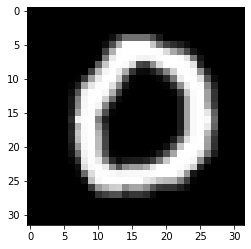

In [104]:
plt.imshow((image[0, 0] + 1) / 2, cmap='gray')

In [105]:
ae = ae.to('cpu')

with torch.no_grad():
    rec_image = ae(image)

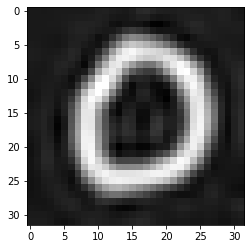

In [106]:
plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

Autoencoder does not work as a generative model :(

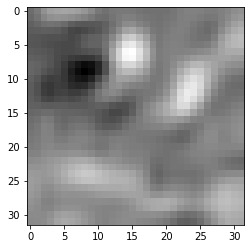

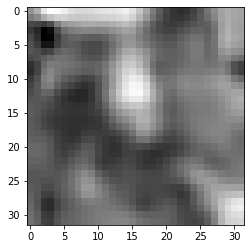

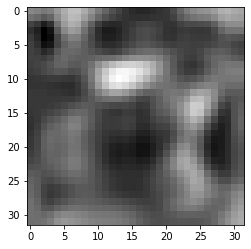

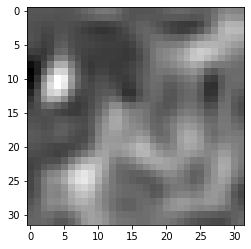

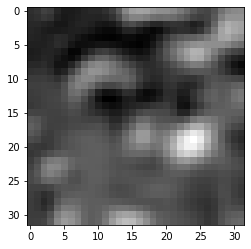

In [107]:
z = ae.encode(image)

for _ in range(5):
    with torch.no_grad():
        z = torch.randn_like(z)
        rec_image = ae.decode(z)

    plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')
    plt.show()

## 2. Variational Autoencoder

![](https://machinelearningmastery.ru/img/0-641830-557317.png)

$$
\mathcal{L}_{VAE} = \underbrace{\mathbb{E}_{q_{\phi}(z|x)} \Big[\log p_{\theta}(x|z)\Big]}_{\text{reconstruction loss}} + \underbrace{KL\big(q_{\phi}(z|x) \big|\big|p(z)\big)}_{\text{latent regularization}}
$$

$$
\log p_{\theta}(x|z) \propto \frac{1}{2} \Big\|x - \mu_{\theta}(z)\Big\|_2^2
$$

$$
q_{\phi}(z|x) = \mathcal{N}\Big(z\Big|\mu_{\phi}(x), \text{diag}(\sigma_{\phi}^2(x))\Big) \Rightarrow KL\big(q_{\phi}(z|x) \big|\big|p(z)\big) = -d + \sum_{i=1}^d \Big( -\log \sigma_i^2 + \sigma_i^2 + \mu_i^2\Big)
$$

In [108]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=4),
        )

    def forward(self, x):
        z = self.net(x)
        z_mu, z_log_sigma_sq = z[:, :64], z[:, 64:]
        return z_mu, z_log_sigma_sq


class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
        )

    def forward(self, z):
        x_mu = self.net(z)
        return x_mu


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, log_sigma_sq, eps):
        return mu + torch.exp(0.5 * log_sigma_sq) * eps

    def forward(self, x):
        z_mu, z_log_sigma_sq = self.encode(x)
        eps = torch.randn_like(z_mu)
        z = self.reparameterize(z_mu, z_log_sigma_sq, eps)
        x_mu = self.decode(z)
        return z_mu, z_log_sigma_sq, x_mu


class VAELoss(nn.Module):
    def forward(self, x, z_mu, z_log_sigma_sq, x_mu):
        z_sigma_sq = torch.exp(z_log_sigma_sq)
        rec_loss = ((x - x_mu).square()).sum() / x.shape[0]
        rec_loss = 0.5 * rec_loss

        kl_loss = (-1 + -z_log_sigma_sq + z_sigma_sq + z_mu.square()).sum() / x.shape[0]
        kl_loss = 0.5 * kl_loss
        return rec_loss + kl_loss

In [109]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
criterion = VAELoss()

In [110]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    vae.train()
    train_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        out = vae(images)
        loss = criterion(images, *out)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.shape[0]

    vae.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, _ in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
            images = images.to(device)
            out = vae(images)
            loss = criterion(images, *out)
            test_loss += loss.item() * images.shape[0]

    train_loss /= len(train_set)
    test_loss /= len(test_set)
    print(f'Epoch {epoch}/{num_epochs}: train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')

Training 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing 1/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/20: train loss: 109.709, test loss: 86.143


Training 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/20: train loss: 77.914, test loss: 71.109


Training 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/20: train loss: 67.403, test loss: 63.985


Training 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/20: train loss: 61.871, test loss: 59.883


Training 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/20: train loss: 58.628, test loss: 56.945


Training 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/20: train loss: 56.386, test loss: 55.104


Training 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/20: train loss: 54.719, test loss: 53.546


Training 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/20: train loss: 53.393, test loss: 52.361


Training 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/20: train loss: 52.348, test loss: 51.615


Training 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/20: train loss: 51.469, test loss: 50.676


Training 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/20: train loss: 50.724, test loss: 50.106


Training 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/20: train loss: 50.140, test loss: 49.539


Training 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/20: train loss: 49.659, test loss: 49.035


Training 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/20: train loss: 49.209, test loss: 48.617


Training 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/20: train loss: 48.826, test loss: 48.373


Training 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/20: train loss: 48.506, test loss: 48.136


Training 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/20: train loss: 48.244, test loss: 47.895


Training 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/20: train loss: 47.973, test loss: 47.613


Training 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/20: train loss: 47.684, test loss: 47.427


Training 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Testing 20/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/20: train loss: 47.523, test loss: 47.159


In [111]:
image = test_set[77][0].unsqueeze(0)

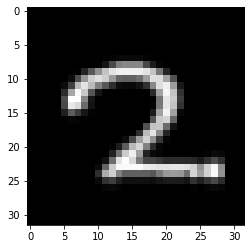

In [112]:
plt.imshow((image[0, 0] + 1) / 2, cmap='gray')

In [113]:
vae = vae.to('cpu')
with torch.no_grad():
    _, _, rec_image = vae(image)

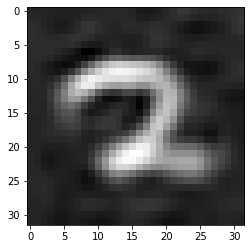

In [114]:
plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

Unconditional sampling (from standard normal -- prior for latents)

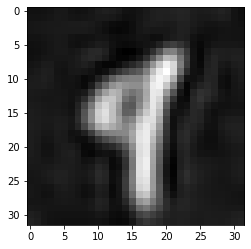

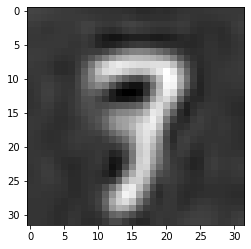

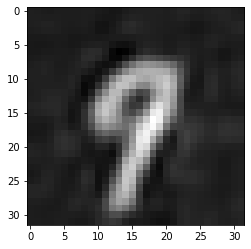

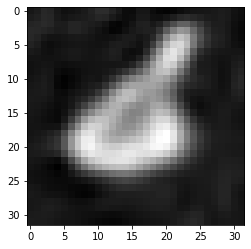

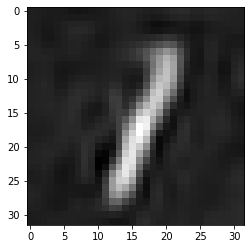

In [118]:
z_mu, z_log_sigma_sq = vae.encode(image)

for _ in range(5):
    with torch.no_grad():
        z = torch.randn_like(z_mu)
        rec_image = vae.decode(z)

    plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')
    plt.show()

Conditional sampling (from latents posterior)

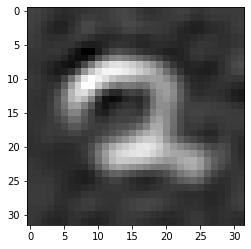

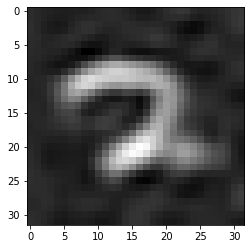

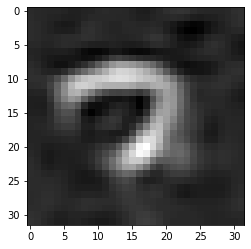

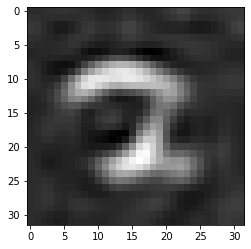

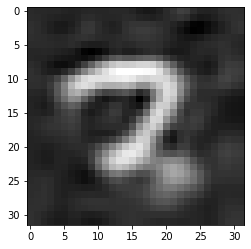

In [116]:
z_mu, z_log_sigma_sq = vae.encode(image)

for _ in range(5):
    with torch.no_grad():
        eps = torch.randn_like(z_mu)
        z = vae.reparameterize(z_mu, z_log_sigma_sq, eps)
        rec_image = vae.decode(z)

    plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')
    plt.show()